# t-distributed Stochastic Neighbour Embedding from Scratch
***
## Table of Contents
1. [Introduction](#1-introduction)
1. [Loading Data](#2-loading-data)
1. [High-Dimensional Affinities](#3-high-dimensional-affinities)
    - [Shannon Entropy and Probability Distribution](#shannon-entropy-and-probability-distribution)
    - [Binary Search](#binary-search)
    - [Pairwise Affinities](#pairwise-affinities)
1. [Low-Dimensional Affinities](#4-low-dimentional-affinities)
1. [Kullback-Leibler Divergence](#5-kullback-leibler-divergence)
1. [Gradient Calculation in t-SNE](#6-gradient-calculation-in-t-sne)
1. [t-SNE Optimisation](#7-t-sne-optimisation)
1. [Visualisation](#8-visualisation)
1. [Encapsulation](#9-encapsulation)
1. [Testing](#10-testing)
1. [Comparison with Scikit-Learn](#11-comparsion-with-scikit-learn)
1. [References](#12-references)
***

In [ ]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import TSNE
import time
import random

## 1. Introduction
t-distributed Stochastic Neighbour Embedding (t-SNE) is a non-linear dimensionality reduction algorithm for visualising high-dimensional data in reduced spaces (typically 2D or 3D) without losing as less information as possible. Similar points stay close together and dissimilar points are kept apart within the space. This method models the relationships between data points as probability distribution in both the original and reduced spaces, then minimises the difference between these distributions. 

Steps of t-SNE algorithm are as follows:

1. Calculate pairwise distances in high-dimensional space.
2. Convert distances to probabilities $P_{ij}$ using a Gaussian kernel.
3. Initialise low-dimensional points randomly.
4. Compute low-dimensional affinities $Q_{ij}$ using a Student's t-distribution.
5. Use gradient calculation to minimise KL divergence and update low-dimensional points iteratively.
6. After all epochs, output the optimised low-dimensional points.

## 2. Loading Data

In [ ]:
# Generate Swiss Roll data
data, colour = make_swiss_roll(n_samples=1000, noise=0.05)
print(f"Shape:{data.shape}")

Shape:(1000, 3)


## 3. High-Dimensional Affinities
Firstly, we will compute symmetric probability matrix $P$ in high-dimensional space using perplexity-based Gaussian kernels. For each point $x$, the conditional probability $p_{j|i}$ is:

\begin{align*}
    p_{j|i} = \dfrac{e^{(-\beta_i ||x_i - x_j||^2)}}{\sum_{k \neq i} e^{(-\beta_i||x_i-x_k||^2)}}
\end{align*}

where $\beta_i = \dfrac{1}{2\sigma^2_i}$ is optimised via binary search to achieve **target entropy** $H_i = \log_2(\text{perplexity})$. 

### Shannon Entropy and Probability Distribution
For given distances $D_{ij}$ and precision parameter $\beta$, we can compute probability distribution and Shannon entropy as follows:
- Raw probabilities: $w_{i} = \text{e}^{-\beta \cdot D_{ij}}$
- Normalised probabilities: $P_j = \dfrac{w_i}{\sum_{k} w_k}$
- Shannon Entropy: $H(P) = -\sum_{j}P_j \log_{2}{(P_j + \epsilon)}$

where $\epsilon = 10^{-10}$ is a constant to prevent numerical instability.

In the high-dimensional space, the similarities between points follow a **Gaussian (normal) distribution**.

In [ ]:
def shannon_and_p_dist(
    D_i: NDArray[np.float64], beta: float
) -> tuple[float, NDArray[np.float64]]:
    """
    Compute Shannon entropy and probability distribution with numerical stability.

    Args:
        D_i: Squared Euclidean distances from point i to others (shape: [n-1]).
        beta: Precision parameter (inverse variance).

    Returns:
        H: Shannon entropy in bits.
        P: Probability distribution (shape: [n-1]).
    """
    P = np.exp(-D_i * beta)  # Unnormalised proba
    P_sum = np.sum(P)
    if P_sum == 0:
        P = np.zeros_like(P)
        H = 0
    else:
        P = P / P_sum  # Proba normalisation
        H = -np.sum(P * np.log2(P + 1e-10))  # Shannon entropy
    return H, P

### Binary Search
Applying a binary search algorithm allows us to find $\beta$ that produces probability distribution with **target entropy** $H_i = \log_2(\text{perplexity})$.

For each point $x_i$:
1. Initialise $\beta_i$ and bounds $\beta_{min}$, $\beta_{max}$.
2. Use `shannon_and_p_dist()` to compute entropy $H_i$ and probabilities $p_{j|i}$.
3. Adjust $\beta_i$ in loops until $|H_i - \log_2{\text{(perplexity)}}| < \text{tol}$ or $i$ reaches its limit.

During the loops:
- Case 1: Entropy too high (H_diff > 0)
    - Need higher $\beta$ to make distribution peakier.
    - Update lower bound: `beta_min = beta`.
    - If upper bound is infinite: `beta *= 2.0` (exponential increase).
    - Else: `beta = (beta + beta_max) / 2.0` (bisection).

- Case 2: Entropy too low (H_diff <= 0)
    - Need lower $\beta$ to spread distribution.
    - Update upper bound: `beta_max = beta`.
    - If lower bound is infinite: `beta /= 2.0` (exponential decrease).
    - Else: beta = `(beta + beta_min) / 2.0` (bisection).

- Termination conditions:
    - `abs(H_diff) <= tol` (Solution found)
    - `i >= max_iter` (Infinite loop prevention)

In [ ]:
def binary_search_beta(
    D_i: NDArray[np.float64],
    target_entropy: float,
    tol: float = 1e-5,
    max_iter: int = 50,
    initial_beta: float = 1.0,
) -> NDArray[np.float64]:
    """
    Binary search for beta that produces target entropy.

    Args:
        D_i: Squared Euclidean distances (shape: [n-1]).
        target_entropy : Target Shannon entropy (log2(perplexity)).
        tol: Tolerance for convergence.
        max_iter: Maximum binary search iterations.
        initial_beta: Starting beta value.

    Returns:
        Probability distribution for the point (shape: [n-1]).
    """
    beta = initial_beta
    beta_min, beta_max = -np.inf, np.inf
    H, proba_distribution = shannon_and_p_dist(D_i, beta)
    H_diff = H - target_entropy
    i = 0

    while np.abs(H_diff) > tol and i < max_iter:
        if H_diff > 0:  # Entropy too high -> increase beta
            beta_min = beta
            if beta_max == np.inf or beta_max == -np.inf:
                beta *= 2.0
            else:
                beta = (beta + beta_max) / 2.0
        else:  # Entropy too low -> decrease beta
            beta_max = beta
            if beta_min == np.inf or beta_min == -np.inf:
                beta /= 2.0
            else:
                beta = (beta + beta_min) / 2.0

        H, proba_distribution = shannon_and_p_dist(D_i, beta)
        H_diff = H - target_entropy
        i += 1

    return proba_distribution

### Pairwise Affinities
The following function calculates symmetric probability matrix $P$ where $P_{ij}$ represents similarity probability. $P_{ij}$ is expressed as:

\begin{align*}
    P_{ij} = \dfrac{p_{j|i} + p_{i|j}}{2N}
\end{align*}

where $p_{ji}$ is conditional probability from `binary_search_beta()`:


\begin{align*}
    p_{j|i} = \dfrac{e^{(-\beta_i ||x_i - x_j||^2)}}{\sum_{k \neq i} e^{(-\beta_i||x_i-x_k||^2)}}
\end{align*}

with $\beta_i = \dfrac{1}{2\sigma^2_i}$ optimised via binary search to match **target entropy** $H_i = \log_2(\text{perplexity})$. 

Note that:
- $P_{ij} = P_{ji}$.
- $p_{ij} = p_{ji}^T$.
- $\text{target entropy} = \log_2{(\text{perplexity})}$, thus $\text{perplexity} = 2H$ where $H$ is **Shannon entropy**.
- $D$ is Squared Euclidean Distances: $D_{ij} = ||x_i - x_j||^2$

In [ ]:
def pairwise_affinities(X, perplexity=30.0, tol=1e-5, max_iter=50):
    """
    Compute high-dimensional affinity matrix P.

    Args:
        X: Input data matrix (shape: [n_samples, n_features]).
        perplexity: Perplexity value (controls neighbourhood size).
        tol: Tolerance for convergence.
        max_iter: Maximum binary search iterations.

    Returns:
        P: Symmetrised affinity matrix (shape: [n_samples, n_samples]).
    """
    n = X.shape[0]
    distances = squareform(pdist(X, "sqeuclidean"))
    P = np.zeros((n, n))
    target_entropy = np.log2(perplexity)

    for i in range(n):
        D_i = distances[i, np.concatenate((np.r_[0:i], np.r_[i + 1 : n]))]
        proba_dist = binary_search_beta(D_i, target_entropy, tol, max_iter)
        P[i, np.concatenate((np.r_[0:i], np.r_[i + 1 : n]))] = proba_dist

    # Symmetrise P and normalise
    P = P + P.T
    P /= np.sum(P)
    P = np.maximum(P, 1e-12)
    return P

## 4. Low-Dimentional Affinities
Low-Dimentional Affinities mimic the high-dimensional similarities but use a different probability distribution to better handle the crowded nature of low-dimentional spaces. Given low-dimensional points $y_1$, $y_2$,..., $y_n$, the similarity between points $i$ and $j$ is defined by the joint probability $q_{ij}$:

\begin{align*}
    q_{ij} = \dfrac{(1 + D)^{-1}}{\sum_{k \neq l}(1 + D)^{-1}}
\end{align*}

where $D$ is the squared Euclidean distance between points $i$ and $j$ in the embedding space. The denominator ensures that all $q_{ij}$ sum to $1$ over all pairs $(i, j)$, making $Q$ a valid probability distribution. Also note that the diagonal elements $q_{ii}$ are set to zero by definition, as a point is not considered similar to itself.

In the low-dimensional embedding space, the similarities between points follow a **Student's t-distiribution** with one degree of freedom (also called **Cauchy Distribution**). The Student's t-distribution is a continuous probability distribution that is symmetric and bell-shaped like the Gaussian distribution, but has heavier tails. The heaviness of the tail is controlled by the degrees of freedom. For a small degree of freedom, the tails are much heavier than the Gaussian distribution. As the degree of freedom increases, t-distribution approaches the Gaussian distribution.

The heavier tails allow distant points to be modelled as very far apart, reducing the 'crowding problem' and helping clusters separate more clearly in the embedding.

After computing squared Euclidean distances $D$, we look for:

\begin{align*}
    D_{ij} = ||y_i||^2 + ||y_j||^2 - 2y_i^T y_j
\end{align*}

Then compute $Q$:

\begin{align*}
    Q_{ij} = (1+D_{ij})^{-1}\\

    Q = \dfrac{Q}{\sum{Q}} \text{ with } Q_{ii} = 0
\end{align*}

In [ ]:
def low_dimensional_affinities(
    Y: NDArray[np.float64],
) -> tuple[NDArray[np.float64], NDArray[np.float64]]:
    """
    Compute low-dimensional affinity matrix Q and distance matrix D.

    Args:
        Y: Low-dimensional embeddings (shape: [n_samples, dim]).

    Returns:
        Q: Low-dimensional affinity matrix (shape: [n_samples, n_samples]).
        D: Squared Euclidean distance matrix (shape: [n_samples, n_samples]).
    """
    sum_Y = np.sum(Y**2, axis=1)
    D = sum_Y[:, None] + sum_Y[None, :] - 2 * np.dot(Y, Y.T)  # Squared Euclidean
    Q = 1 / (1 + D)
    np.fill_diagonal(Q, 0)
    Q /= np.sum(Q)
    return Q, D  # Return both

## 5. Kullback-Leibler Divergence
The KL Divergence measures dissimilarity between distributions $P$ (high-D) and $Q$ (low-D):

\begin{align*}
    C = KL(P||Q) = \sum_{i \neq j} p_{ij} \log{\dfrac{p_{ij}}{q_{ij}}} = \underbrace{\sum_{i \neq j} p_{ij} \log{p_{ij}}}_{\text{constant}} - \sum_{i \neq j} p_{ij} \log{q_{ij}}
\end{align*}

The first term $\sum_{i \neq j} p_{ij} \log{p_{ij}}$ is a constant, therefore only the second term depends on embeddings $y_i$:

Taking the derivative of $C$ with respect to $y_i$:

\begin{align*}
    \dfrac{\partial C}{\partial y_i} = - \sum_{j} p_{ij} \dfrac{\partial \log{q_{ij}}}{\partial y_i} + \underbrace{\sum_{j} \log q_{ij} \dfrac{\partial p_{ij}}{\partial y_i}}_{\text{=0}}
\end{align*}

Since $p_{ij}$ is constant in low-D space, the gradient simplifies to:

\begin{align*}
    \dfrac{\partial C}{\partial y_i} = 4 \sum_{j}(p_{ij} - q_{ij}) \cdot (1 + ||y_i - y_j||^2)^{-1} \cdot (y_i - y_j)
\end{align*}

## 6. Gradient Calculation in t-SNE
The gradient calculation minimises the Kullback-Leibler (KL) divergence between high-dimensional affinities $P$ and low-dimensional affinities $Q$. The gradient function computes:

\begin{align*}
    \dfrac{\partial C}{\partial y_i} = 4 \sum_{j}(p_{ij} - q_{ij}) \cdot (1 + ||y_i - y_j||^2)^{-1} \cdot (y_i - y_j)
\end{align*}

where:
- $C = KL(P||Q)$: Cost function.
- $p_{ij}$: High-dimensional affinity.
- $q_{ij}$: Low-dimensional affinity.
- $y_i$: Low-dimensional embedding.

This gradient calculation drives the optimisation:

- **Attractive forces**: Where $p_{ij} > q_{ij}$ (pull points together)
- **Repulsive forces**: Where $p_{ij} < q_{ij}$ (push points apart)

In [ ]:
def gradient(
    P: NDArray[np.float64],
    Q: NDArray[np.float64],
    Y: NDArray[np.float64],
    D: NDArray[np.float64],
) -> NDArray[np.float64]:
    """
    Compute gradient of KL divergence.

    Args:
        P: High-dimensional affinity matrix.
        Q: Low-dimensional affinity matrix.
        Y: Current embeddings.
        D: Squared Euclidean distance matrix.

    Returns:
        Gradient matrix (shape: [n_samples, dim]).
    """
    PQ = P - Q
    inv_distances = 1 / (1 + D)
    np.fill_diagonal(inv_distances, 0)
    weighted_differences = np.expand_dims(PQ * inv_distances, axis=2) * (
        Y[:, None, :] - Y[None, :, :]
    )
    return 4 * np.sum(weighted_differences, axis=1)

## 7. t-SNE Optimisation
In this function, the following two optimisation techniques are applied:
- **Early Exaggeration**: $P \leftarrow P \times 4.0$ amplifies attractive forces initially to escape local minima. 
- **Momentum**: Accelerates convergence via velocity updates:
\begin{align*}
    \text{velocity} = \text{momentum} \times \text{velocity} - \text{lr} \times \nabla_yC
\end{align*}

Steps:
1. Initialisation
    - Random embedding $Y \sim \mathcal{N}(0, 10^{-4})$
    - Compute $P$ with early exaggeration.
2. Iteration
    - Compute $Q$ and $D$.
    - Calculate gradient of KL $\dfrac{\partial C}{\partial Y}$
    - Update momentum.
    - Update embedding: $Y \leftarrow Y + \text{velocity}$

In [ ]:
def tsne(
    X: NDArray[np.float64],
    random_state: int,
    dim: int = 2,
    perplexity: float = 30.0,
    lr: int = 200,
    max_iter: int = 1000,
    early_exaggeration: float = 4.0,
    exaggeration_iter: int = 100,
    momentum: float = 0.5,
    final_momentum: float = 0.8,
) -> NDArray[np.float64]:
    """
    Compute t-SNE embedding of input data.

    Args:
        X: Input data matrix (shape: [n_samples, n_features]).
        dim: Output dimensionality of the embedding (typically 2 or 3). Default=2.
        random_state: Seed for random number generator to ensure reproducible results.
        perplexity: Perplexity value (controls neighbourhood size).
        lr: Learning rate for gradient descent optimisation. Default=200.
        max_iter: Maximum binary search iterations.
        early_exaggeration: Scaling factor to avoid tight sters and to escape local minima. Default=4.0.
        exaggeration_iter: Iteration at which early exaggeration stops and P-matrix is scaled down. Default=100.
        momentum: Momentum factor for gradient updates during early exaggeration phase. Accelerates optimisation in relevant directions. Default=0.5.
        final_momentum: Momentum factor for gradient updates after early exaggeration phase. Default=0.8.

    Returns:
        Y: Low-dimensional embedding (shape: [n_samples, dim]).
    """
    if random_state is not None:
        np.random.seed(random_state)
    n = X.shape[0]
    Y = np.random.normal(0, 1e-4, (n, dim))
    P = pairwise_affinities(X, perplexity)
    P *= early_exaggeration
    velocity = np.zeros_like(Y)

    for i in range(max_iter):
        Q, D = low_dimensional_affinities(Y)
        grad = gradient(P, Q, Y, D)
        if i == exaggeration_iter:
            P /= early_exaggeration
        mom = final_momentum if i > exaggeration_iter else momentum
        velocity = mom * velocity - lr * grad
        Y += velocity

        if i % 100 == 0 or i == max_iter - 1:
            loss = np.sum(P * np.log((P + 1e-12) / (Q + 1e-12)))
            print(f"Iteration {i}: KL divergence = {loss:.4f}")

    return Y

## 8. Visualisation

In [ ]:
def plot_tsne_comparison(
    custom_tsne: NDArray[np.float64],
    sk_tsne: NDArray[np.float64],
    colour: NDArray[np.float64],
) -> None:
    """
    Visualises and compares two t-SNE embeddings side by side with colourbars.

    Args:
        custom_tsne: Low-dimensional embedding from custom t-SNE (shape: [n_samples, 2]).
        sk_tsne: Low-dimensional embedding from scikit-learn t-SNE (shape: [n_samples, 2]).
        colour: Unrolled positions of each point along the Swiss roll. (shape: [n_samples,])
    """

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    sc1 = ax1.scatter(custom_tsne[:, 0], custom_tsne[:, 1], c=colour, cmap="tab10", s=5)
    ax1.set_title("Custom t-SNE Implementation")
    fig.colorbar(sc1, ax=ax1)

    sc2 = ax2.scatter(sk_tsne[:, 0], sk_tsne[:, 1], c=colour, cmap="tab10", s=5)
    ax2.set_title("Scikit-learn t-SNE")
    fig.colorbar(sc2, ax=ax2)

    plt.tight_layout()
    plt.show()

## 9. Encapsulation

## 10. Testing

In [ ]:
import numpy as np


class CustomTSNE:
    """
    Custom implementation of t-Distributed Stochastic Neighbour Embedding (t-SNE).

    Attributes:
        embedding_: Store the final embedding after calling fit_transform (shape: [n_samples, dim])
    """

    def __init__(
        self,
        dim: int = 2,
        perplexity: float = 30.0,
        lr: int = 200,
        max_iter: int = 1000,
        early_exaggeration: float = 4.0,
        exaggeration_iter: int = 100,
        momentum: float = 0.5,
        final_momentum: float = 0.8,
        random_state: NDArray[np.float64] | None = None,
    ) -> None:
        """
        Initialise t-SNE parameters.

        Args:
            dim: Output dimensionality of the embedding (typically 2 or 3). Default=2.
            perplexity: Target perplexity for probability distributions in high-dimensional space. Default=30.0.
            lr: Learning rate for gradient descent optimisation. Default=200.
            max_iter: Number of optimisation iterations. Default=1000.
            early_exaggeration:
                Scaling factor applied to P-matrix to prevent tight clusters and to escape local minima. Default=4.0.
            exaggeration_iter: Iteration at which early exaggeration stops and P-matrix is scaled down. Default=100.
            momentum: Momentum factor for gradient updates. Accelerates optimisation in relevant directions. Default=0.5
            final_momentum: Momentum factor for gradient updates after early exaggeration phase. Default=0.8.
            random_state: Seed for random number generator to ensure reproducible results.
        """
        self.dim = dim
        self.perplexity = perplexity
        self.lr = lr
        self.max_iter = max_iter
        self.early_exaggeration = early_exaggeration
        self.exaggeration_iter = exaggeration_iter
        self.momentum = momentum
        self.final_momentum = final_momentum
        self.random_state = random_state
        self.embedding_ = None

    def _shannon_and_p_dist(
        self, D_i: NDArray[np.float64], beta: float
    ) -> tuple[float, NDArray[np.float64]]:
        """
        Compute Shannon entropy and probability distribution with numerical stability.

        Args:
            D_i: Squared Euclidean distances from point i to others (shape: [n-1]).
            beta: Precision parameter (inverse variance).

        Returns:
            H: Shannon entropy in bits.
            P: Probability distribution (shape: [n-1]).
        """
        P = np.exp(-D_i * beta)
        P_sum = np.sum(P)
        if P_sum == 0:
            P = np.zeros_like(P)
            H = 0
        else:
            P /= P_sum
            H = -np.sum(P * np.log2(P + 1e-10))
        return H, P

    def _binary_search_beta(
        self,
        D_i: NDArray[np.float64],
        target_entropy: float,
        tol: float = 1e-5,
        max_iter: int = 50,
        initial_beta: float = 1.0,
    ) -> NDArray[np.float64]:
        """
        Binary search for beta that produces target entropy.

        Args:
            D_i: Squared Euclidean distances (shape: [n-1]).
            target_entropy: Target Shannon entropy (log2(perplexity)).
            tol: Tolerance for convergence.
            max_iter: Maximum binary search iterations.
            initial_beta: Starting beta value.

        Returns:
            Probability distribution for the point (shape: [n-1]).
        """
        beta = initial_beta
        beta_min, beta_max = -np.inf, np.inf
        H, proba_distribution = self._shannon_and_p_dist(D_i, beta)
        H_diff = H - target_entropy
        i = 0

        while np.abs(H_diff) > tol and i < max_iter:
            if H_diff > 0:
                beta_min = beta
                if np.isinf(beta_max):
                    beta *= 2.0
                else:
                    beta = (beta + beta_max) / 2.0
            else:
                beta_max = beta
                if np.isinf(beta_min):
                    beta /= 2.0
                else:
                    beta = (beta + beta_min) / 2.0

            H, proba_distribution = self._shannon_and_p_dist(D_i, beta)
            H_diff = H - target_entropy
            i += 1

        return proba_distribution

    def _pairwise_affinities(self, X: NDArray[np.float64]) -> NDArray[np.float64]:
        """
        Compute high-dimensional affinity matrix P.

        Args:
            X: Input data matrix (shape: [n_samples, n_features]).

        Returns:
            P: Symmetrised affinity matrix (shape: [n_samples, n_samples]).
        """
        n = X.shape[0]
        distances = squareform(pdist(X, "sqeuclidean"))
        P = np.zeros((n, n))
        target_entropy = np.log2(self.perplexity)

        for i in range(n):
            D_i = distances[i, np.concatenate((np.r_[0:i], np.r_[i + 1 : n]))]
            proba_dist = self._binary_search_beta(D_i, target_entropy)
            P[i, np.concatenate((np.r_[0:i], np.r_[i + 1 : n]))] = proba_dist

        P = (P + P.T) / (2 * n)
        P = np.maximum(P, 1e-12)
        return P

    def _low_dimensional_affinities(
        self, Y: NDArray[np.float64]
    ) -> tuple[NDArray[np.float64], NDArray[np.float64]]:
        """
        Compute low-dimensional affinity matrix Q and distance matrix D.

        Args:
            Y: Low-dimensional embeddings (shape: [n_samples, dim]).

        Returns:
            Q: Low-dimensional affinity matrix (shape: [n_samples, n_samples]).
            D: Squared Euclidean distance matrix (shape: [n_samples, n_samples]).
        """
        sum_Y = np.sum(Y**2, axis=1)
        D = sum_Y[:, None] + sum_Y[None, :] - 2 * np.dot(Y, Y.T)
        Q = 1 / (1 + D)
        np.fill_diagonal(Q, 0)
        Q /= np.sum(Q)
        return Q, D

    def _gradient(
        self,
        P: NDArray[np.float64],
        Q: NDArray[np.float64],
        Y: NDArray[np.float64],
        D: NDArray[np.float64],
    ) -> NDArray[np.float64]:
        """
        Compute gradient of KL divergence.

        Args:
            P: High-dimensional affinity matrix.
            Q: Low-dimensional affinity matrix.
            Y: Current embeddings.
            D: Squared Euclidean distance matrix.

        Returns:
            Gradient matrix (shape: [n_samples, dim]).
        """
        PQ = P - Q
        inv_distances = 1 / (1 + D)
        np.fill_diagonal(inv_distances, 0)
        weighted_differences = np.expand_dims(PQ * inv_distances, axis=2) * (
            Y[:, None, :] - Y[None, :, :]
        )
        return 4 * np.sum(weighted_differences, axis=1)

    def fit_transform(self, X: NDArray[np.float64]) -> NDArray[np.float64]:
        """
        Compute t-SNE embedding of input data.

        Args:
            X: Input data matrix (shape: [n_samples, n_features]).

        Returns:
            Y: Low-dimensional embedding (shape: [n_samples, dim]).
        """
        if self.random_state is not None:
            random.seed(self.random_state)
            np.random.seed(self.random_state)

        n = X.shape[0]
        Y = np.random.normal(0, 1e-4, (n, self.dim))
        P = self._pairwise_affinities(X)
        P *= self.early_exaggeration
        velocity = np.zeros_like(Y)

        for i in range(self.max_iter):
            Q, D = self._low_dimensional_affinities(Y)
            grad = self._gradient(P, Q, Y, D)

            if i == self.exaggeration_iter:
                P /= self.early_exaggeration

            mom = self.final_momentum if i > self.exaggeration_iter else self.momentum
            velocity = mom * velocity - self.lr * grad
            Y += velocity

            if i % 100 == 0 or i == self.max_iter - 1:
                loss = np.sum(P * np.log((P + 1e-12) / (Q + 1e-12)))
                print(f"Iteration {i}: KL divergence = {loss:.4f}")

        self.embedding_ = Y
        return Y

In [ ]:
# Custom t-SNE
print("Running custom t-SNE...")

start = time.time()
model = CustomTSNE(dim=2, max_iter=1000, perplexity=30, random_state=0, lr=200)
custom_tsne = model.fit_transform(data)
custom_time = time.time() - start

Running custom t-SNE...
Iteration 0: KL divergence = 19.4689
Iteration 100: KL divergence = 1.4735
Iteration 200: KL divergence = 0.6268
Iteration 300: KL divergence = 0.5535
Iteration 400: KL divergence = 0.5227
Iteration 500: KL divergence = 0.5054
Iteration 600: KL divergence = 0.4941
Iteration 700: KL divergence = 0.4862
Iteration 800: KL divergence = 0.4803
Iteration 900: KL divergence = 0.4758
Iteration 999: KL divergence = 0.4721


## 11. Comparsion with Scikit-Learn


Running scikit-learn t-SNE...
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.521147
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.014902
[t-SNE] KL divergence after 1000 iterations: 0.430105

Custom t-SNE time: 42.91s
Scikit-learn t-SNE time: 15.18s


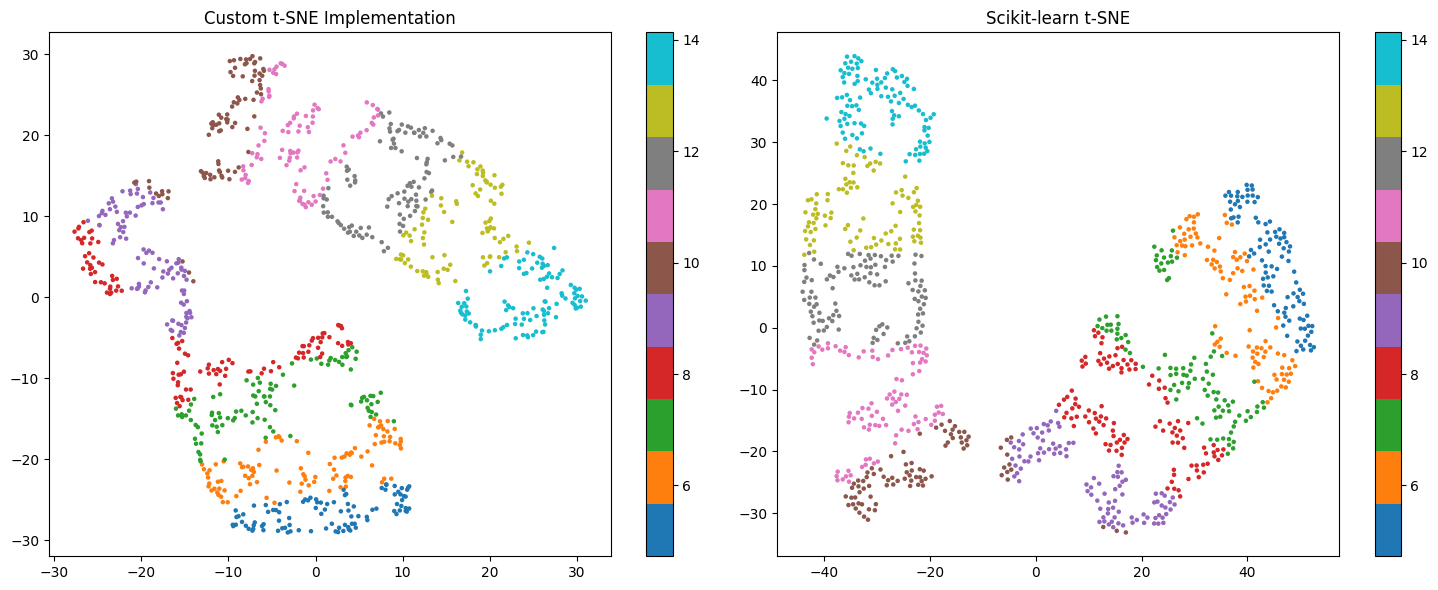

In [ ]:
# Scikit-learn t-SNE
print("\nRunning scikit-learn t-SNE...")
start = time.time()
sk_tsne = TSNE(
    n_components=2,
    perplexity=30,
    max_iter=1000,
    learning_rate=200,
    random_state=0,
    method="exact",
    init="pca",
    verbose=1,
).fit_transform(data)
sk_time = time.time() - start

print(f"\nCustom t-SNE time: {custom_time:.2f}s")
print(f"Scikit-learn t-SNE time: {sk_time:.2f}s")

plot_tsne_comparison(custom_tsne, sk_tsne, colour)

## 12. References

1. DataMListic. (2025). *t-SNE - Explained* [YouTube Video]. <br>
https://youtu.be/b-AvYLqLWd0

1. Kemal Erdem (burnpiro). (2020). *t-SNE clearly explained*. <br>
https://medium.com/data-science/t-sne-clearly-explained-d84c537f53a

1. Sachinsoni. (2024). *Mastering t-SNE(t-distributed stochastic neighbor embedding)*. <br>
https://medium.com/@sachinsoni600517/mastering-t-sne-t-distributed-stochastic-neighbor-embedding-0e365ee898ea

1. scikit-learn. (n.d.). *t-SNE: The effect of various perplexity values on the shape — scikit-learn Examples.* <br>
https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html

1. scikit-learn. (n.d.). *TSNE — scikit-learn API Reference.* <br>
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

1. StatQuest with Josh Starmer. (2017). *StatQuest: t-SNE, Clearly Explained* [YouTube Video]. <br>
https://youtu.be/FgakZw6K1QQ